# Covid-Net Hospitalization Data EDA

Goals:
* Understand all the columns and type
* Get regional hospitalization time series and plot it with bar chart (try interactive country plotly later)

Dataset Schema:
* Catchment - Where the cases were recorded initially
* Network - The networks are the COVID-19-Associated Hospitalization Surveillance Network (COVID-NET) (EIP and IHSP surveillance networks combined),
Emerging Infections Program (EIP) only, and Influenza Hospitalization Surveillance Project (IHSP) only
* MMWR-WEEK - The weeks are assigned according to the calendar date on which the week ends. Range from 1-53, although most years consist of 52 weeks. 2020 Week 10 ends at March 7 Saturday, 2020.

In [84]:
import re
import datetime
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 100)
plt.style.use('Solarize_Light2')

## Load Data


In [85]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hacklytics-2021/COVID-19Surveillance_All_Data.csv')
data.head()

,CATCHMENT,NETWORK,YEAR,MMWR-YEAR,MMWR-WEEK,AGE CATEGORY,SEX,RACE,CUMULATIVE RATE,WEEKLY RATE
0,Tennessee,EIP,2020,2020,10,Overall,Overall,Overall,0.1,0.1
1,Utah,IHSP,2020,2020,10,Overall,Overall,White,0.0,0.0
2,Utah,IHSP,2020,2020,10,Overall,Overall,Black,0.0,0.0
3,Utah,IHSP,2020,2020,10,Overall,Overall,Hispanic/Latino,0.0,0.0
4,Utah,IHSP,2020,2020,10,Overall,Overall,Asian/Pacific Islander,0.0,0.0


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34272 entries, 0 to 34271
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   catchment        34272 non-null  object 
 1   network          34272 non-null  object 
 2   year             34272 non-null  int64  
 3   mmwr_year        34272 non-null  int64  
 4   mmwr_week        34272 non-null  int64  
 5   age_category     34272 non-null  object 
 6   sex              34272 non-null  object 
 7   race             34272 non-null  object 
 8   cumulative_rate  17136 non-null  float64
 9   weekly_rate      17136 non-null  float64
 10  date             34272 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 2.9+ MB


## Preprocessing

### Renaming DF Column Labels

In [108]:
# preprocess column labels and rename the data dataframe
schema = data.columns
mapper = {}
for i in range(len(schema)):
    # strip extra white spaces and to lower case
    label = schema[i].strip().lower()
    # replace all non-alphebetic characters with '_'
    label = re.sub('[^0-9a-zA-Z]+', '_', label)
    mapper[schema[i]] = label

data = data.rename(columns=mapper)
data.head(1)

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date
0,Tennessee,EIP,2020,2020,10,Overall,Overall,Overall,0.1,0.1,2020-03-07


### Convert and add datetime col

In [107]:
# concat mmwr_year and mmwr_week together as a new column <yyyyww>
data['date'] = data['mmwr_year'].astype(str) + (data['mmwr_week'] -1).astype(str)

# convert date col to a real datetime object
data['date'] = pd.to_datetime(data['date'] +'6', format='%Y%W%w')
data.head(1)

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date
0,Tennessee,EIP,2020,2020,10,Overall,Overall,Overall,0.1,0.1,2020-03-07


In [109]:
# Checkout null rows and see the record classification
null_rows = data[pd.isnull(data['weekly_rate'])]
null_rows.head(12)

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date
6528,Tennessee,EIP,2020,2021,5,Overall,Male,Overall,NaN,NaN,2021-01-30
6529,Tennessee,EIP,2020,2021,5,Overall,Overall,American Indian/Alaska Native,NaN,NaN,2021-01-30
6530,Tennessee,EIP,2020,2021,5,Overall,Female,Overall,NaN,NaN,2021-01-30
6531,Tennessee,EIP,2020,2021,5,Overall,Overall,Overall,NaN,NaN,2021-01-30
6532,Utah,IHSP,2020,2021,5,Overall,Overall,White,NaN,NaN,2021-01-30
6533,Utah,IHSP,2020,2021,5,Overall,Overall,Black,NaN,NaN,2021-01-30
6534,Utah,IHSP,2020,2021,5,Overall,Overall,Hispanic/Latino,NaN,NaN,2021-01-30
6535,Utah,IHSP,2020,2021,5,Overall,Overall,Asian/Pacific Islander,NaN,NaN,2021-01-30
6536,Utah,IHSP,2020,2021,5,Overall,Overall,American Indian/Alaska Native,NaN,NaN,2021-01-30
6537,Utah,IHSP,2020,2021,5,Overall,Male,Overall,NaN,NaN,2021-01-30


The NaN rows are consistent in the sense of cumulative_rate  and weekly_rate is
Nan at iff at the same time. The last valid recorded rate pairs are `mmwr_year
=2021` and `mmwr_week = 4`. Each week for each catchment state is recorded
using 8 row entries for classification.

* We will get rid of the unrecorded rows first and try to plot the **overall 
hospitalization rate for California** and then all states.

### Separting row classifications

In [120]:
# filter for all the valid rows
valid_df = data[pd.notnull(data['weekly_rate'])]

# filter for all overall rows
overall_df = valid_df.loc[(valid_df['age_category'] == 'Overall') &
                          (valid_df['sex'] == 'Overall') &
                          (valid_df['race'] == 'Overall')]
# filter based on sex
sex_df = valid_df.loc[(valid_df['age_category'] == 'Overall') &
                          (valid_df['sex'] != 'Overall') &
                          (valid_df['race'] == 'Overall')]

# filter based on race
race_df = valid_df.loc[(valid_df['age_category'] == 'Overall') &
                          (valid_df['sex'] == 'Overall') &
                          (valid_df['race'] != 'Overall')]

# filter based on age
age_df = valid_df.loc[(valid_df['age_category'] != 'Overall') &
                          (valid_df['sex'] == 'Overall') &
                          (valid_df['race'] == 'Overall')]


print(f'shape of rows with valid rate: {valid_df.shape}')
print(f'shape of overall_df: {overall_df.shape}')
print(f'shape of sex_df: {sex_df.shape}')
print(f'shape of race_df: {race_df.shape}')
print(f'shape of age_df: {age_df.shape}')

shape of rows with valid rate: (17136, 11)
shape of overall_df: (816, 11)
shape of sex_df: (1632, 11)
shape of race_df: (4080, 11)
shape of age_df: (10608, 11)


## Visualization

Subplots of trends of overall cumu_rate/weekly_rate for all states.

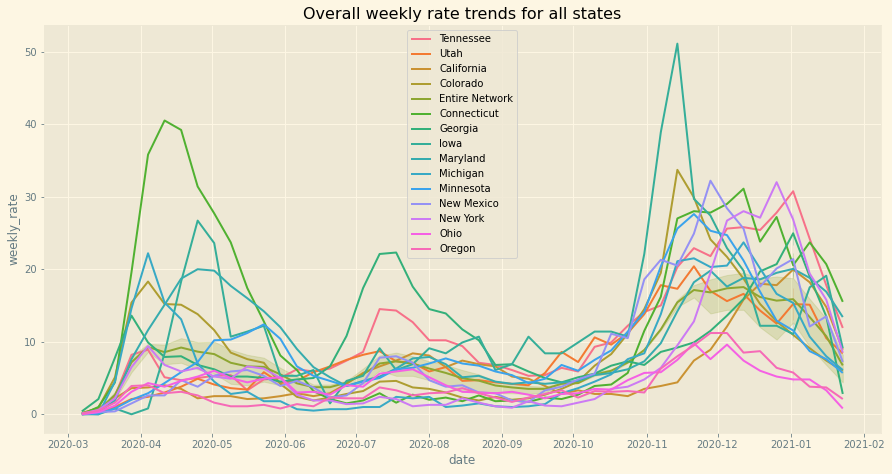

In [126]:
plt.figure(figsize=(15,7.5))
plt.title('Overall weekly rate trends for all states')
sns.lineplot(data=overall_df, x='date', y='weekly_rate', hue='catchment')
plt.legend(loc='best')
plt.show()

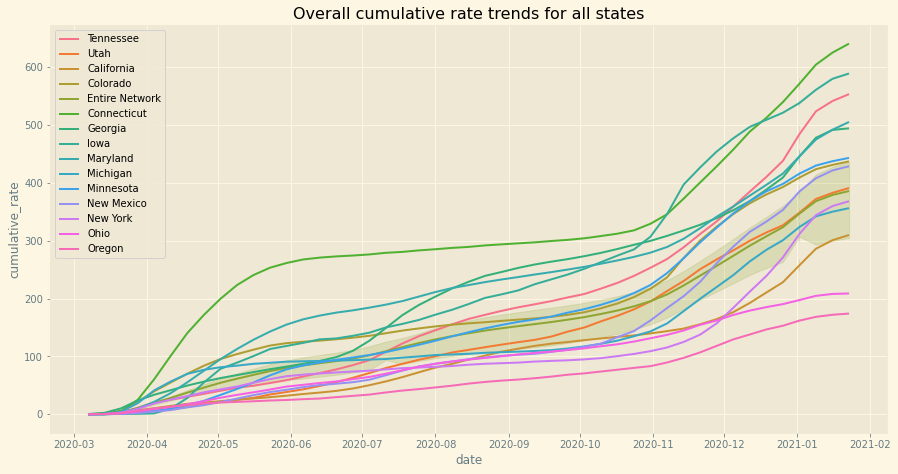

In [127]:
plt.figure(figsize=(15,7.5))
plt.title('Overall cumulative rate trends for all states')
sns.lineplot(data=overall_df, x='date', y='cumulative_rate', hue='catchment')
plt.legend(loc='best')
plt.show()